# E-07. 네이버 영화리뷰 감성분석

- 데이터 준비와 확인
- 데이터로더 구성
- 모델구성을 위한 데이터 분석 및 가공
- 모델구성 및 validation set 구성
- 모델 훈련 개시
- Loss, Accuracy 그래프 시각화
- 학습된 Embedding 레이어 분석
- 한국어 Word2Vec 임베딩 활용하여 성능 개선

---

## 1. 데이터 준비와 확인

활용 데이터: [Naver sentiment movie corpus](https://github.com/e9t/nsmc)

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

In [2]:
train_data.head(5)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
test_data.head(5)

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


---
## 2. 데이터로더 구성
- `stopwords`: 불용어
- `drop_duplicates`: 중복 데이터가 포함된 행 제거
- `dropna`: 누락된 값이 포함된 행이나 열 삭제
    - `axis=0`: 행 삭제, `axis=1`: 열삭제
    - `any`: 하나 이상의 NA가 있으면 행 또는 열 삭제
- `inplace=Ture`: 객체를 새로 선언하지 않고 지금 객체를 업데이트 하고 싶을 때
- `Subset`: 중복 여부를 테스트할 때 colunms의 이름을 리스트 형태로 적음
- `tolist()`: 넘파이 어레이를 리스트로 변환
- `np.concatenate`: Numpy 배열들을 하나로 합치는데 이용

In [4]:
from konlpy.tag import Mecab
tokenizer = Mecab()
# 불용어
stopwords = ['아이고', '의해', '의','가','이','은','들','는','좀','잘',
             '걍','과','도','를','으로','자','에','와','한','하다', '아', '휴',
            '우리', '을', '에게', '로', '물론', '엉엉']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True) # 중복제거
    train_data = train_data.dropna(how = 'any') # 결측값이 있는 행이나 열 제거 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    # 사전word_to_index 구성
    words = np.concatenate(X_train).tolist() # 리스트 안에 리스트를 플랫하게 만드는 것 [[1,2][3,4]] 이걸 [1,2,3,4]
    counter = Counter(words) # counter를 쓰면 셀 수 있다.
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    # 텍스트 스트링을 사전 인덱스 스트링으로 변환하는 함수
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [5]:
print("train data: {} , test data: {}".format(len(X_train), len(X_test))) 
print('word_to_index : ',len(word_to_index), type(word_to_index))

train data: 146182 , test data: 49157
word_to_index :  9997 <class 'dict'>


- `word_to_index` 내에 `<PAD>`, `<BOS>`, `<UNK>`, `<UNUSED>` 가 있는지 확인
- 없으니 인덱스 0~3에 넣어준다.

In [6]:
print('<PAD>' in word_to_index)
print('<BOS>' in word_to_index)
print('<UNK>' in word_to_index)
print('<UNUSED>' in word_to_index)

False
False
False
False


In [7]:
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

In [8]:
print('<PAD>' in word_to_index)
print('<BOS>' in word_to_index)
print('<UNK>' in word_to_index)
print('<UNUSED>' in word_to_index)

True
True
True
True


In [9]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [10]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [11]:
print(X_train[0])
print(get_decoded_sentence(X_train[0], index_to_word))
print(y_train[0])

[71, 913, 4, 4, 36, 223, 19, 30, 743]
빙 . . 진짜 짜증 나 네요 목소리
0


In [12]:
for i in range(5):
    print(X_train[i])
    print(get_decoded_sentence(X_train[i], index_to_word))
    print(y_train[i])

[71, 913, 4, 4, 36, 223, 19, 30, 743]
빙 . . 진짜 짜증 나 네요 목소리
0
[1022, 4, 10, 514, 544, 682, 5, 117, 4, 67, 1632, 49, 919, 1000, 14, 41, 386]
. .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나
1
[23, 200, 3]
재 <UNUSED>
0
[8399, 155, 3917, 4, 4, 293, 91, 16, 6, 4, 4, 55, 3471]
이야기 구먼 . . 솔직히 재미 없 다 . . 평점 조정
0
[3, 8884, 1102, 49, 2825, 57, 5, 13, 2751, 38, 1182, 32, 346, 39, 21, 37, 57, 3, 3, 422, 3094, 1759, 6]
익살 스런 연기 돋보였 던 영화 ! 스파이더맨 에서 늙 어 보이 기 만 했 던 <UNUSED> <UNUSED> 너무나 이뻐 보였 다
1


---
## 3. 모델 구성을 위한데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- `keras.preprocessing.sequence.pad_sequences` 을 활용한 패딩 추가

In [13]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.607477257485705
문장길이 최대 :  116
문장길이 표준편차 :  12.497268361387638
pad_sequences maxlen :  40
전체 문장의 0.9343705046099345%가 maxlen 설정값 이내에 포함됩니다. 


In [14]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 40)


In [15]:
vocab_size = len(word_to_index)  # 딕셔너리에 포함된 단어 개수(어휘 사전 크기)
word_vector_dim = 4     # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

---
## 4. 모델 구성, 훈련

### validation set 구분
- 모델은 3가지 이상 다양하게 구성하여 실험하기
- train 데이터의 25%를 validation set으로 설정하였다 (3500개)

In [16]:
# validation set 3500건 분리
x_val = X_train[:3500]   
y_val = y_train[:3500]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[3500:]  
partial_y_train = y_train[3500:]

print(partial_x_train.shape)
print(partial_y_train.shape)
print(x_val.shape)
print(y_val.shape)

(142682, 40)
(142682,)
(3500, 40)
(3500,)


---

### 여러 모델로 테스트 해보기
- 노드에서 제시해준 LSTM, 1D-CNN, GlobalMaxPooling1D 을 적용해서 결과를 산출해보았다.
- 추가적으로 풀잎스쿨에서 배운 optimizer를 적용하여 각 모델에 적용해보았다.
- 일반적으로 adam을 많이 사용한다고 하였는데 이번 모델에서 가장 좋은 결과를 도출할지 궁금하여 시도해보았다.

### 4-1. LSTM 사용

In [64]:
model1 = keras.Sequential()
model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model1.add(keras.layers.Dense(8, activation='relu'))
model1.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 8)                 6688      
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [65]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history1 = model1.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
1115/1115 [==============================] - 23s 19ms/step - loss: 0.5945 - accuracy: 0.6853 - val_loss: 0.6227 - val_accuracy: 0.6266
Epoch 2/10
1115/1115 [==============================] - 21s 19ms/step - loss: 0.5537 - accuracy: 0.7337 - val_loss: 0.4706 - val_accuracy: 0.8126
Epoch 3/10
1115/1115 [==============================] - 21s 19ms/step - loss: 0.4350 - accuracy: 0.8163 - val_loss: 0.4054 - val_accuracy: 0.8303
Epoch 4/10
1115/1115 [==============================] - 21s 18ms/step - loss: 0.3684 - accuracy: 0.8527 - val_loss: 0.3984 - val_accuracy: 0.8354
Epoch 5/10
1115/1115 [==============================] - 20s 18ms/step - loss: 0.3558 - accuracy: 0.8624 - val_loss: 0.4253 - val_accuracy: 0.8260
Epoch 6/10
1115/1115 [==============================] - 21s 18ms/step - loss: 0.3522 - accuracy: 0.8675 - val_loss: 0.4032 - val_accuracy: 0.8383
Epoch 7/10
1115/1115 [==============================] - 21s 19ms/step - loss: 0.3228 - accuracy: 0.8757 - val_loss: 0.3834 -

In [66]:
results1 = model1.evaluate(X_test,  y_test, verbose=2)

print(results1)

1537/1537 - 5s - loss: 0.3857 - accuracy: 0.8441
[0.3856655955314636, 0.8440710306167603]


### 4-2. 1-D Convolution Neural Network(1-D CNN) 사용

In [20]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(32, 3, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 3, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 4)           40004     
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          416       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1552      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [21]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history2 = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
1115/1115 [==============================] - 13s 8ms/step - loss: 0.5125 - accuracy: 0.7255 - val_loss: 0.3388 - val_accuracy: 0.8511
Epoch 2/10
1115/1115 [==============================] - 5s 5ms/step - loss: 0.3235 - accuracy: 0.8615 - val_loss: 0.3349 - val_accuracy: 0.8486
Epoch 3/10
1115/1115 [==============================] - 5s 5ms/step - loss: 0.2934 - accuracy: 0.8783 - val_loss: 0.3367 - val_accuracy: 0.8503
Epoch 4/10
1115/1115 [==============================] - 5s 5ms/step - loss: 0.2714 - accuracy: 0.8896 - val_loss: 0.3432 - val_accuracy: 0.8500
Epoch 5/10
1115/1115 [==============================] - 5s 5ms/step - loss: 0.2564 - accuracy: 0.8957 - val_loss: 0.3535 - val_accuracy: 0.8463
Epoch 6/10
1115/1115 [==============================] - 5s 5ms/step - loss: 0.2459 - accuracy: 0.9005 - val_loss: 0.3631 - val_accuracy: 0.8457
Epoch 7/10
1115/1115 [==============================] - 5s 5ms/step - loss: 0.2344 - accuracy: 0.9074 - val_loss: 0.3831 - val_accuracy

In [22]:
results2 = model.evaluate(X_test,  y_test, verbose=2)

print(results2)

1537/1537 - 5s - loss: 0.4068 - accuracy: 0.8382
[0.40681061148643494, 0.8381716012954712]


### 4-3. GlobalMaxPooling1D 사용

In [23]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 4)           40004     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 40,053
Trainable params: 40,053
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history3 = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
1115/1115 [==============================] - 5s 4ms/step - loss: 0.6024 - accuracy: 0.6649 - val_loss: 0.3933 - val_accuracy: 0.8246
Epoch 2/10
1115/1115 [==============================] - 4s 3ms/step - loss: 0.3796 - accuracy: 0.8331 - val_loss: 0.3775 - val_accuracy: 0.8371
Epoch 3/10
1115/1115 [==============================] - 4s 3ms/step - loss: 0.3470 - accuracy: 0.8501 - val_loss: 0.3769 - val_accuracy: 0.8394
Epoch 4/10
1115/1115 [==============================] - 4s 3ms/step - loss: 0.3276 - accuracy: 0.8602 - val_loss: 0.3804 - val_accuracy: 0.8383
Epoch 5/10
1115/1115 [==============================] - 4s 3ms/step - loss: 0.3200 - accuracy: 0.8641 - val_loss: 0.3842 - val_accuracy: 0.8337
Epoch 6/10
1115/1115 [==============================] - 4s 3ms/step - loss: 0.3124 - accuracy: 0.8672 - val_loss: 0.3881 - val_accuracy: 0.8309
Epoch 7/10
1115/1115 [==============================] - 4s 3ms/step - loss: 0.3073 - accuracy: 0.8703 - val_loss: 0.3912 - val_accuracy:

In [25]:
results3 = model.evaluate(X_test,  y_test, verbose=2)

print(results3)

1537/1537 - 2s - loss: 0.4062 - accuracy: 0.8252
[0.4061557650566101, 0.8251520395278931]


###  4-4. LSTM + SGD

In [26]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 4)           40004     
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 416       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 40,501
Trainable params: 40,501
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history4 = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
1115/1115 [==============================] - 10s 8ms/step - loss: 0.6931 - accuracy: 0.5028 - val_loss: 0.6931 - val_accuracy: 0.4937
Epoch 2/10
1115/1115 [==============================] - 8s 7ms/step - loss: 0.6930 - accuracy: 0.5042 - val_loss: 0.6929 - val_accuracy: 0.5123
Epoch 3/10
1115/1115 [==============================] - 8s 7ms/step - loss: 0.6930 - accuracy: 0.5072 - val_loss: 0.6932 - val_accuracy: 0.4937
Epoch 4/10
1115/1115 [==============================] - 8s 7ms/step - loss: 0.6929 - accuracy: 0.5059 - val_loss: 0.6928 - val_accuracy: 0.5126
Epoch 5/10
1115/1115 [==============================] - 8s 7ms/step - loss: 0.6930 - accuracy: 0.5038 - val_loss: 0.6928 - val_accuracy: 0.5149
Epoch 6/10
1115/1115 [==============================] - 8s 7ms/step - loss: 0.6929 - accuracy: 0.5036 - val_loss: 0.6927 - val_accuracy: 0.5126
Epoch 7/10
1115/1115 [==============================] - 8s 7ms/step - loss: 0.6928 - accuracy: 0.5058 - val_loss: 0.6927 - val_accuracy

In [28]:
results4 = model.evaluate(X_test,  y_test, verbose=2)

print(results4)

1537/1537 - 4s - loss: 0.6929 - accuracy: 0.4973
[0.6928703784942627, 0.4973045587539673]


###  4-5. LSTM + RMSprop

In [17]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 4)           40004     
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 416       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 40,501
Trainable params: 40,501
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(optimizer='RMSprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history5 = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
1115/1115 [==============================] - 12s 8ms/step - loss: 0.5562 - accuracy: 0.6852 - val_loss: 0.3523 - val_accuracy: 0.8426
Epoch 2/10
1115/1115 [==============================] - 8s 7ms/step - loss: 0.3551 - accuracy: 0.8460 - val_loss: 0.3363 - val_accuracy: 0.8529
Epoch 3/10
1115/1115 [==============================] - 8s 7ms/step - loss: 0.3389 - accuracy: 0.8547 - val_loss: 0.3432 - val_accuracy: 0.8471
Epoch 4/10
1115/1115 [==============================] - 8s 7ms/step - loss: 0.3311 - accuracy: 0.8576 - val_loss: 0.3249 - val_accuracy: 0.8580
Epoch 5/10
1115/1115 [==============================] - 8s 7ms/step - loss: 0.3215 - accuracy: 0.8619 - val_loss: 0.3270 - val_accuracy: 0.8563
Epoch 6/10
1115/1115 [==============================] - 8s 7ms/step - loss: 0.3196 - accuracy: 0.8634 - val_loss: 0.3253 - val_accuracy: 0.8586
Epoch 7/10
1115/1115 [==============================] - 8s 7ms/step - loss: 0.3186 - accuracy: 0.8640 - val_loss: 0.3193 - val_accuracy

In [19]:
results5 = model.evaluate(X_test,  y_test, verbose=2)

print(results5)

1537/1537 - 4s - loss: 0.3413 - accuracy: 0.8506
[0.34131869673728943, 0.8506011366844177]


###  4-6. LSTM + Adagrad

In [32]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 4)           40004     
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 416       
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 40,501
Trainable params: 40,501
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(optimizer='Adagrad',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history6 = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
1115/1115 [==============================] - 10s 7ms/step - loss: 0.6931 - accuracy: 0.5009 - val_loss: 0.6931 - val_accuracy: 0.4937
Epoch 2/10
1115/1115 [==============================] - 8s 7ms/step - loss: 0.6931 - accuracy: 0.5051 - val_loss: 0.6931 - val_accuracy: 0.4937
Epoch 3/10
1115/1115 [==============================] - 8s 7ms/step - loss: 0.6931 - accuracy: 0.5001 - val_loss: 0.6931 - val_accuracy: 0.4937
Epoch 4/10
1115/1115 [==============================] - 8s 7ms/step - loss: 0.6930 - accuracy: 0.4973 - val_loss: 0.6931 - val_accuracy: 0.4826
Epoch 5/10
1115/1115 [==============================] - 8s 7ms/step - loss: 0.6930 - accuracy: 0.5017 - val_loss: 0.6930 - val_accuracy: 0.5154
Epoch 6/10
1115/1115 [==============================] - 8s 7ms/step - loss: 0.6930 - accuracy: 0.5023 - val_loss: 0.6930 - val_accuracy: 0.5151
Epoch 7/10
1115/1115 [==============================] - 8s 7ms/step - loss: 0.6930 - accuracy: 0.5076 - val_loss: 0.6930 - val_accuracy

In [34]:
results6 = model.evaluate(X_test,  y_test, verbose=2)

print(results6)

1537/1537 - 4s - loss: 0.6930 - accuracy: 0.5102
[0.6929829120635986, 0.5101816654205322]


### 4-7. LSTM + Adamax

In [35]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 4)           40004     
_________________________________________________________________
lstm_4 (LSTM)                (None, 8)                 416       
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 40,501
Trainable params: 40,501
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.compile(optimizer='Adamax',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history7 = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
1115/1115 [==============================] - 10s 8ms/step - loss: 0.6931 - accuracy: 0.5017 - val_loss: 0.6918 - val_accuracy: 0.5309
Epoch 2/10
1115/1115 [==============================] - 8s 7ms/step - loss: 0.5861 - accuracy: 0.6854 - val_loss: 0.4099 - val_accuracy: 0.8154
Epoch 3/10
1115/1115 [==============================] - 8s 7ms/step - loss: 0.4104 - accuracy: 0.8171 - val_loss: 0.3709 - val_accuracy: 0.8309
Epoch 4/10
1115/1115 [==============================] - 8s 7ms/step - loss: 0.3808 - accuracy: 0.8328 - val_loss: 0.3559 - val_accuracy: 0.8366
Epoch 5/10
1115/1115 [==============================] - 8s 7ms/step - loss: 0.3621 - accuracy: 0.8428 - val_loss: 0.3498 - val_accuracy: 0.8414
Epoch 6/10
1115/1115 [==============================] - 8s 7ms/step - loss: 0.3514 - accuracy: 0.8488 - val_loss: 0.3439 - val_accuracy: 0.8449
Epoch 7/10
1115/1115 [==============================] - 8s 7ms/step - loss: 0.3404 - accuracy: 0.8550 - val_loss: 0.3395 - val_accuracy

In [37]:
results7 = model.evaluate(X_test,  y_test, verbose=2)

print(results7)

1537/1537 - 4s - loss: 0.3565 - accuracy: 0.8415
[0.35648593306541443, 0.8415077924728394]


---

## 5.  Loss, Accuracy 그래프 시각화 시각화
### 5-1.  `LSTM`, `1D-CNN`, `GlobalMaxPooling1D 3`  비교하기 (Training & Validation)

In [38]:
history_dict1 = history1.history
history_dict2 = history2.history
history_dict3 = history3.history
history_dict4 = history4.history
history_dict5 = history5.history
history_dict6 = history6.history
history_dict7 = history7.history

In [39]:
model1_acc = history_dict1['accuracy']
model2_acc = history_dict2['accuracy']
model3_acc = history_dict3['accuracy']
model4_acc = history_dict4['accuracy']
model5_acc = history_dict5['accuracy']
model6_acc = history_dict6['accuracy']
model7_acc = history_dict7['accuracy']

model1_vacc = history_dict1['val_accuracy']
model2_vacc = history_dict2['val_accuracy']
model3_vacc = history_dict3['val_accuracy']
model4_vacc = history_dict4['val_accuracy']
model5_vacc = history_dict5['val_accuracy']
model6_vacc = history_dict6['val_accuracy']
model7_vacc = history_dict7['val_accuracy']


model1_loss = history_dict1['loss']
model2_loss = history_dict2['loss']
model3_loss = history_dict3['loss']
model4_loss = history_dict4['loss']
model5_loss = history_dict5['loss']
model6_loss = history_dict6['loss']
model7_loss = history_dict7['loss']

model1_val_loss = history_dict1['val_loss']
model2_val_loss = history_dict2['val_loss']
model3_val_loss = history_dict3['val_loss']
model4_val_loss = history_dict4['val_loss']
model5_val_loss = history_dict5['val_loss']
model6_val_loss = history_dict6['val_loss']
model7_val_loss = history_dict7['val_loss']

m1_tacc = results1[1]
m2_tacc = results2[1]
m3_tacc = results3[1]
m4_tacc = results4[1]
m5_tacc = results5[1]
m6_tacc = results6[1]
m7_tacc = results7[1]

m1_tloss = results1[0]
m2_tloss = results2[0]
m3_tloss = results3[0]
m4_tloss = results4[0]
m5_tloss = results5[0]
m6_tloss = results6[0]
m7_tloss = results7[0]


<Figure size 432x288 with 0 Axes>

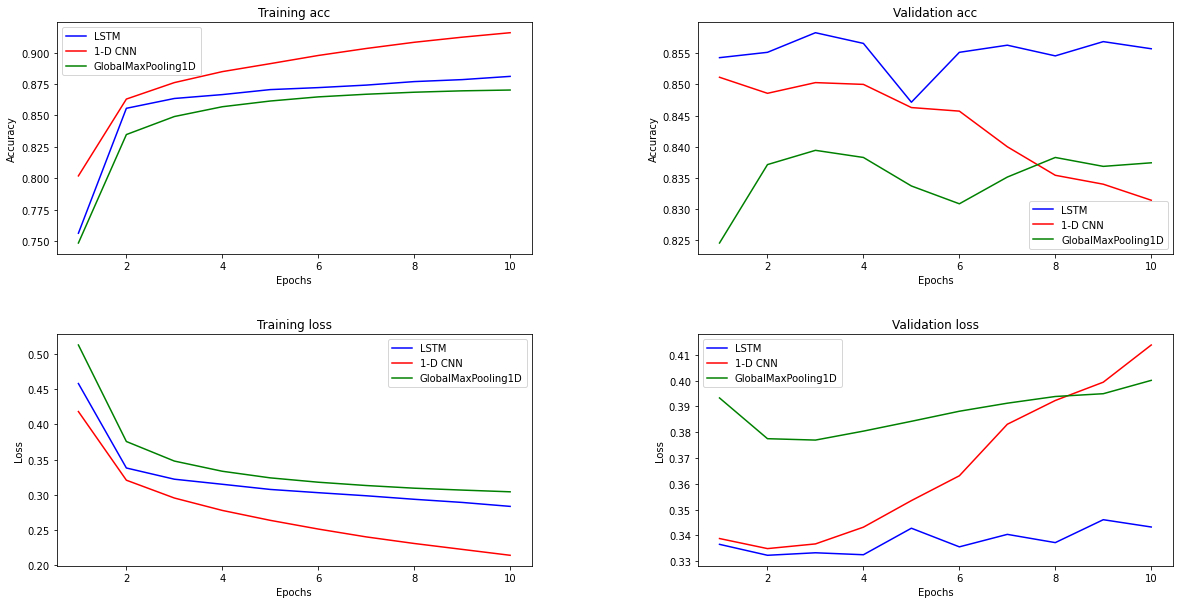

In [40]:
epochs = range(1, 11)

plt.clf() 

plt.figure(figsize=(20,10))
plt.subplots_adjust(wspace=0.35, hspace=0.35)

plt.subplot(221)
plt.plot(epochs, model1_acc, 'b', label='LSTM')
plt.plot(epochs, model2_acc, 'r', label='1-D CNN')
plt.plot(epochs, model3_acc, 'g', label='GlobalMaxPooling1D')
plt.title('Training acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(222)
plt.plot(epochs, model1_vacc, 'b', label='LSTM')
plt.plot(epochs, model2_vacc, 'r', label='1-D CNN')
plt.plot(epochs, model3_vacc, 'g', label='GlobalMaxPooling1D')
plt.title('Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(223)
plt.plot(epochs, model1_loss, 'b', label='LSTM')
plt.plot(epochs, model2_loss, 'r', label='1-D CNN')
plt.plot(epochs, model3_loss, 'g', label='GlobalMaxPooling1D')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(224)
plt.plot(epochs, model1_val_loss, 'b', label='LSTM')
plt.plot(epochs, model2_val_loss, 'r', label='1-D CNN')
plt.plot(epochs, model3_val_loss, 'g', label='GlobalMaxPooling1D')
plt.title('Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.show()

- 먼저 `LSTM`, `1D-CNN`, `GlobalMaxPooling1D 3` 세가지 모델의 Training acc, training loss, validation acc, validation loss를 하나의 그래프로 나타내어 비교해보았다.
<br>
<br>
- 1-D CNN
    - Training acc에서 가장 높은 수준의 acc를 보였으며, Training loss 값도 가장 낮았고 점진적으로 하향하는 모습을 볼 수 있다.
    - 하지만 Validation 그래프를 보면 LSTM에 비해 acc가 낮고 점차적으로 하향하는 모습을 볼 수 있다.
    - 또한 validation loss를 보면 loss 값이 epoch가 커질수록 급경사 형태로 상향되며 가장 높은 loss를 나타내는 것을 볼 수 있다.
<br>
<br>
- LSTM
    - Training acc 에서는 1-D CNN에 비해 낮은 수준의 acc를 보이지만 수치 상으로 보았을 때 0.85 이상의 acc를 보인다. 
    - Training loss를 보면 1-D CNN보다 loss 값이 높지만 점진적으로 하향하는 모습을 볼 수 있다.
    - Validation acc에서도 0.85 이상의 acc를 보이는 것을 볼 수 있으며, loss 값도 세 모델 중 가장 낮은 것을 볼 수 있다.
    <br><br>
- GlobalMaxPooling1D
    - Training 결과를 보면 세 모델 중 가장 낮은 acc와 가장 높은 loss 값을 유지하는 것을 알 수 있다.
    - vlaidation 결과에서도 마찬가지의 결과를 보였다.
    <br><br>
- 위 데이터들로만 판단했을 때는 `LSTM`이 해당 데이터에 가장 적합한 모델이라고 느껴졌다. 
---


### 5-2.  'Adam', 'SGD', 'RMSprop', 'Adagrad', 'Adamax'  비교하기 (Training & Validation)

<Figure size 432x288 with 0 Axes>

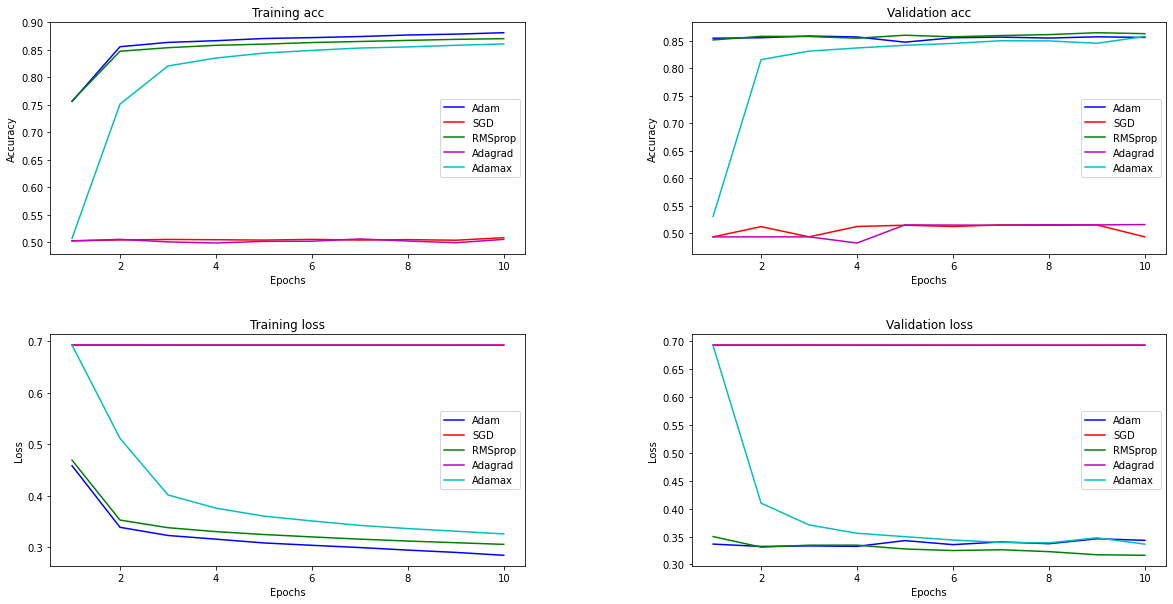

In [41]:
epochs = range(1, 11)

plt.clf() 

plt.figure(figsize=(20,10))
plt.subplots_adjust(wspace=0.35, hspace=0.35)

plt.subplot(221)
plt.plot(epochs, model1_acc, 'b', label='Adam')
plt.plot(epochs, model4_acc, 'r', label='SGD')
plt.plot(epochs, model5_acc, 'g', label='RMSprop')
plt.plot(epochs, model6_acc, 'm', label='Adagrad')
plt.plot(epochs, model7_acc, 'c', label='Adamax')
plt.title('Training acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(222)
plt.plot(epochs, model1_vacc, 'b', label='Adam')
plt.plot(epochs, model4_vacc, 'r', label='SGD')
plt.plot(epochs, model5_vacc, 'g', label='RMSprop')
plt.plot(epochs, model6_vacc, 'm', label='Adagrad')
plt.plot(epochs, model7_vacc, 'c', label='Adamax')
plt.title('Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(223)
plt.plot(epochs, model1_loss, 'b', label='Adam')
plt.plot(epochs, model4_loss, 'r', label='SGD')
plt.plot(epochs, model5_loss, 'g', label='RMSprop')
plt.plot(epochs, model6_loss, 'm', label='Adagrad')
plt.plot(epochs, model7_loss, 'c', label='Adamax')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(224)
plt.plot(epochs, model1_val_loss, 'b', label='Adam')
plt.plot(epochs, model4_val_loss, 'r', label='SGD')
plt.plot(epochs, model5_val_loss, 'g', label='RMSprop')
plt.plot(epochs, model6_val_loss, 'm', label='Adagrad')
plt.plot(epochs, model7_val_loss, 'c', label='Adamax')
plt.title('Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.show()

- 가장 좋은 성능을 보인다고 판단 된 `LSTM`에 풀잎스쿨에서 배운 옵티마이저를 여러개 적용해서 비교해보았다.
- 옵티마이저는 'Adam', 'SGD', 'RMSprop', 'Adagrad', 'Adamax'를 사용했다.
<br><br>
- Training acc & loss
    - `Adam`과 `RMSprop`, `Adamax`가 높은 acc를 보이는 것을 알 수 있으며, loss 값 역시도 두 옵티마이저를 적용했을 때 상대적으로 낮은 것을 알 수 있다.
    - Training 결과를 보면  `Adam`과 `RMSprop`, `Adamax`를 제외한 모델들은 acc가 매우 낮고, loss 값이 큰 것을 보아 해당 데이터에 적합하지 않다고 생각된다.
    <br><br>
- Validation acc & loss
    - validation에서도 역시  `Adam`과 `RMSprop`, `Adamax`가 우세하였으며, 다른 모델들은 적합하지 않아 보인다.
    - `Adam`은 training 에서는 acc, loss 면에서 `RMSprop` 보다 미세하게 우세하였으나, validation에서는 그 반대의 모습을 보이고 있는 점이 흥미로웠다.

---

### 5-3.  `LSTM`, `1D-CNN`, `GlobalMaxPooling1D 3`  비교하기 (Test)
- 그렇다면 test 결과는 어땠을까?
-  `LSTM`, `1D-CNN`, `GlobalMaxPooling1D 3` 3가지 모델은 먼저 비교해보자

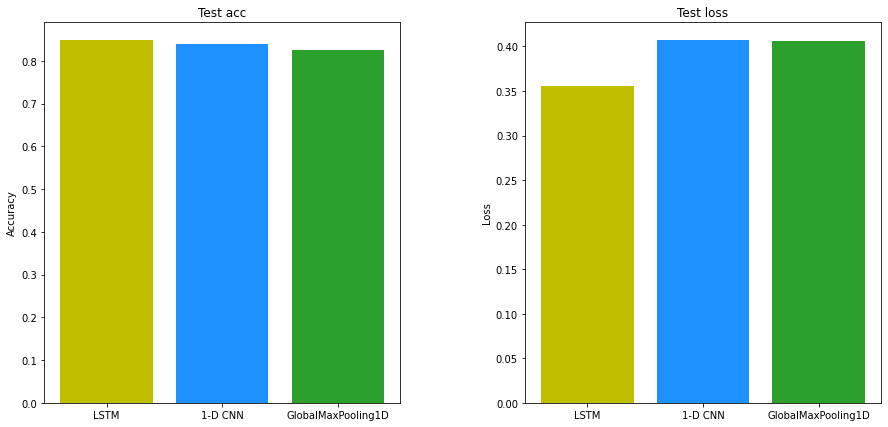

In [42]:
x = np.arange(3)
label1 = ['LSTM', '1-D CNN', 'GlobalMaxPooling1D']
test_accs1 = [m1_tacc, m2_tacc, m3_tacc]
test_loss1 = [m1_tloss, m2_tloss, m3_tloss]
colors = ['y', 'dodgerblue', 'C2']

plt.figure(figsize=(15,7))
plt.subplots_adjust(wspace=0.35, hspace=0.35)

plt.subplot(121)
plt.bar(x, test_accs1, color=colors)
plt.xticks(x, label1)
plt.title('Test acc')
plt.ylabel('Accuracy')

plt.subplot(122)
plt.bar(x, test_loss1, color=colors)
plt.xticks(x, label1)
plt.title('Test loss')
plt.ylabel('Loss')

plt.show()

- 막대형 그래프로  `LSTM`, `1D-CNN`, `GlobalMaxPooling1D 3` 모델들을 비교해보았다.
- test 결과에서 `LSTM`이 가장 높은 acc 와 가장 낮은 loss 값을 보였다.

---

### 5-2.  'Adam', 'SGD', 'RMSprop', 'Adagrad', 'Adamax'  비교하기 (Test)
옵티마이저를 다르게 적용한 LSTM들의 test 결과도 확인해보자

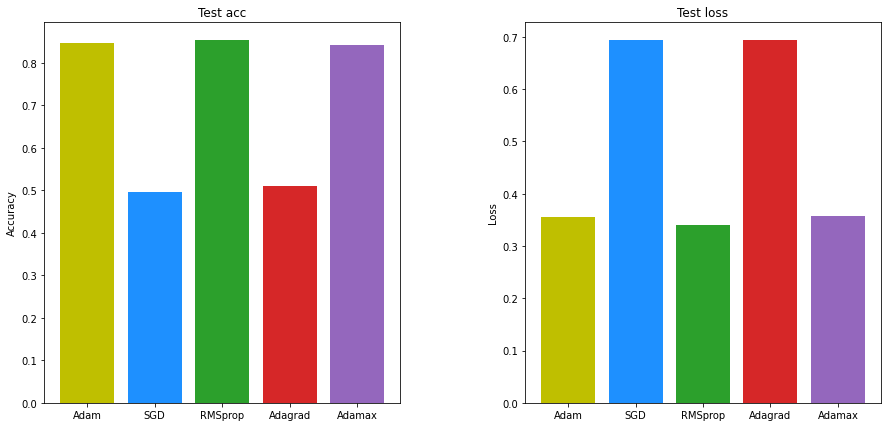

In [43]:
z = np.arange(5)
label2 = ['Adam', 'SGD','RMSprop', 'Adagrad', 'Adamax']
test_accs2 = [m1_tacc, m4_tacc, m5_tacc, m6_tacc, m7_tacc]
test_loss2 = [m1_tloss, m4_tloss, m5_tloss, m6_tloss, m7_tloss]
colors = ['y', 'dodgerblue', 'C2', 'C3', 'C4']

plt.figure(figsize=(15,7))
plt.subplots_adjust(wspace=0.35, hspace=0.35)

plt.subplot(121)
plt.bar(z, test_accs2, color=colors)
plt.xticks(z, label2)
plt.title('Test acc')
plt.ylabel('Accuracy')

plt.subplot(122)
plt.bar(z, test_loss2, color=colors)
plt.xticks(z, label2)
plt.title('Test loss')
plt.ylabel('Loss')



plt.show()

- 옵티마이저들도 역시 막대형 그래프로 test 결과를 비교해보았다.
- `RMSprop`이 가장 높은 acc와 loss를 보였으며, 그 다음으로는 `Adam`과 `Adamax`가 비슷한 성능으로 우세하였다.
- test 결과에서도 역시 세 모델을 제외한 나머지 모델들의 성능은 좋지 못했다.

--- 
### 전체 모델 test 결과 비교하기

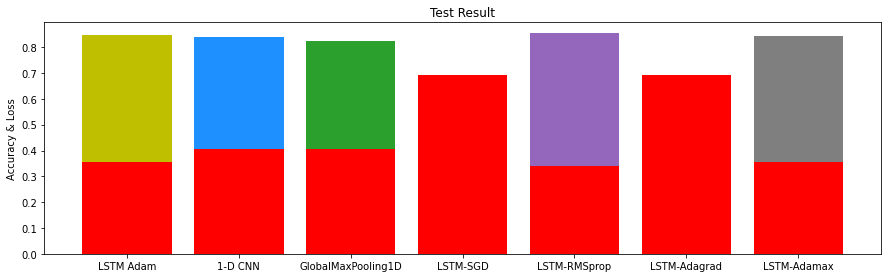

In [45]:
k = np.arange(7)
label3 = ['LSTM Adam', '1-D CNN', 'GlobalMaxPooling1D', 'LSTM-SGD','LSTM-RMSprop', 'LSTM-Adagrad', 'LSTM-Adamax']
test_accs3 = [m1_tacc, m2_tacc, m3_tacc, m4_tacc, m5_tacc, m6_tacc, m7_tacc]
test_loss3 = [m1_tloss, m2_tloss, m3_tloss, m4_tloss, m5_tloss, m6_tloss, m7_tloss]
colors = ['y', 'dodgerblue', 'C2', 'C3', 'C4', 'C5', "C7"]

plt.figure(figsize=(15,10))
plt.subplots_adjust(wspace=0.35, hspace=0.35)

plt.subplot(211)
plt.bar(k, test_accs3, color=colors)
plt.bar(k, test_loss3, color='r')
plt.xticks(k, label3)
plt.title('Test Result')
plt.ylabel('Accuracy & Loss')

plt.show()

- 전체 모델들의 test 결과를 시각화 해보았다.
- 붉은 색으로 표시된 것은 test loss 값이며, 나머지 색상들은 모두 test acc를 나타낸다.
- 전체 모델 중 **`LSTM`에 `RMSprop`을 사용한 모델이 test acc 0.8531, test loss 0.3407 가장 성능이 좋은 것으로 나타났다.**

---
## 7. 학습된 Embedding 레이어 분석

In [20]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)  

(10001, 4)


In [21]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(len(index_to_word)-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,len(index_to_word)):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [22]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [23]:
word_vectors.similar_by_word("사랑")

[('짠해', 0.9999656081199646),
 ('삶', 0.999783992767334),
 ('벤', 0.9997737407684326),
 ('덜덜', 0.9997439980506897),
 ('박용우', 0.9997013807296753),
 ('이정현', 0.999628484249115),
 ('매혹', 0.9995113015174866),
 ('담긴', 0.9994324445724487),
 ('기뻤', 0.9993832111358643),
 ('금성무', 0.9993435740470886)]

In [24]:
word_vectors.similar_by_word("죽음")

[('남긴', 0.9998047351837158),
 ('실제', 0.9997484087944031),
 ('문자', 0.9997034072875977),
 ('돋', 0.999535083770752),
 ('짧', 0.9995003938674927),
 ('EBS', 0.9994606375694275),
 ('상상력', 0.9993327260017395),
 ('자격', 0.9992017149925232),
 ('극도', 0.9990943670272827),
 ('감동', 0.9989983439445496)]

In [25]:
word_vectors.similar_by_word("행복")

[('공중', 0.9997889995574951),
 ('비롯', 0.9997423887252808),
 ('선장', 0.9995591640472412),
 ('너머', 0.9995328783988953),
 ('도박', 0.9991116523742676),
 ('so', 0.9990561604499817),
 ('이소룡', 0.9990420937538147),
 ('오프닝', 0.9987783432006836),
 ('자세', 0.9987423419952393),
 ('엘리베이터', 0.9987382292747498)]

- Word2Vec이 영어로 되어있다보니 한글 단어로 유사한 단어를 찾기에 어려움이 느껴진다.

---

## 8. 한국어 Word2Vec 임베딩 활용하여 성능 개선
- 한국어 버전의 Word2Vec을 활용하기 위해서는 반드시 !! gensim 버전을 확인해야한다.
- 계속 오류가 나타나서 해결하려고 많은 시간을 보냈는데 버전만 다운그레이드 해주면 되는 문제였다.
- gensim 3.8.3으로 버전을 변경한 후 적용하니 ko.bin 파일을 제대로 불러올 수 있었다.

In [26]:
!pip install gensim==3.8.3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


- gensim 버전 변경이 잘 되었는지 확인

In [27]:
import gensim
gensim.__version__

'3.8.3'

In [28]:
import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'

In [29]:
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['사랑'] 
vector

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([-1.3740246 , -1.7353463 ,  3.3915305 , -2.569253  , -1.4016607 ,
        1.4556127 ,  0.9414557 ,  1.9207907 ,  0.16471806,  0.4838317 ,
       -0.8547181 ,  2.0879807 ,  0.86741775,  0.87539405, -0.09962013,
        0.22928311, -1.1858722 ,  0.00858838,  1.4999928 , -0.16196461,
       -0.35184434, -0.92390764,  1.0849575 ,  0.3025011 ,  2.7021565 ,
       -1.0263684 ,  0.32864776, -0.76589465, -2.510981  , -0.66225356,
        2.8434615 ,  0.50130975, -1.021874  , -1.4366034 ,  1.1110784 ,
        0.5812605 , -0.5830406 , -0.5785423 ,  1.3634988 ,  2.3074338 ,
       -1.4314893 ,  0.45745876,  1.1073523 , -3.2135262 , -0.2898375 ,
       -1.1622221 ,  1.2369208 , -0.7622987 , -0.37757635,  1.1376442 ,
        0.01065568, -0.69105595,  1.5159112 ,  1.1534518 , -1.0119992 ,
       -0.5757404 ,  1.1349088 , -1.1289831 ,  0.13004152,  2.0451715 ,
       -0.23940353,  1.3604902 ,  0.72700524,  0.32545742,  1.0612459 ,
        0.42252553,  1.1442151 ,  2.8774905 ,  2.4377263 , -1.34

In [30]:
word2vec.wv.most_similar("사랑")

[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [31]:
word2vec.wv.most_similar("죽음")

[('운명', 0.6403501629829407),
 ('슬픔', 0.6214146614074707),
 ('영혼', 0.5676152110099792),
 ('괴로움', 0.5649088621139526),
 ('악몽', 0.5648330450057983),
 ('아픔', 0.5566291809082031),
 ('고난', 0.5450730323791504),
 ('시련', 0.543346643447876),
 ('세상', 0.542243480682373),
 ('죄책감', 0.5393192768096924)]

In [32]:
word2vec.wv.most_similar("행복")

[('사랑', 0.6759077310562134),
 ('기쁨', 0.6493781805038452),
 ('즐거움', 0.6396492719650269),
 ('삶', 0.6299898028373718),
 ('젊음', 0.6187379360198975),
 ('즐겁', 0.6027448177337646),
 ('인생', 0.6002243161201477),
 ('존엄', 0.5952589511871338),
 ('고독', 0.5938762426376343),
 ('불행', 0.5894461870193481)]

- 앞서 사용했던 키워드를 그대로 사용하였지만, 한국어 Word2Vec을 활용하니 보다 유의미한 결과가 나오는 것을 확인할 수 있다.
---
### 모델 학습
이전 모델들 중 가장 성능이 좋다고 판단되었던 `LSTM +RMSprop`, `LSTM +Adam`모델로 학습을 진행하였다.

#### LSTM + Adam

In [48]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [49]:
from tensorflow.keras.initializers import Constant
# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size,
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 40, 200)           2000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 6688      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history8 = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
1115/1115 [==============================] - 23s 19ms/step - loss: 0.6234 - accuracy: 0.6037 - val_loss: 0.3850 - val_accuracy: 0.8351
Epoch 2/10
1115/1115 [==============================] - 20s 18ms/step - loss: 0.3604 - accuracy: 0.8460 - val_loss: 0.3345 - val_accuracy: 0.8603
Epoch 3/10
1115/1115 [==============================] - 20s 18ms/step - loss: 0.3063 - accuracy: 0.8744 - val_loss: 0.3254 - val_accuracy: 0.8577
Epoch 4/10
1115/1115 [==============================] - 20s 18ms/step - loss: 0.2756 - accuracy: 0.8872 - val_loss: 0.3219 - val_accuracy: 0.8569
Epoch 5/10
1115/1115 [==============================] - 21s 18ms/step - loss: 0.2590 - accuracy: 0.8951 - val_loss: 0.3314 - val_accuracy: 0.8569
Epoch 6/10
1115/1115 [==============================] - 21s 19ms/step - loss: 0.2417 - accuracy: 0.9036 - val_loss: 0.3367 - val_accuracy: 0.8577
Epoch 7/10
1115/1115 [==============================] - 21s 18ms/step - loss: 0.2206 - accuracy: 0.9136 - val_loss: 0.3553 -

In [51]:
results8 = model.evaluate(X_test,  y_test, verbose=2)

print(results8)

1537/1537 - 5s - loss: 0.4160 - accuracy: 0.8431
[0.416003555059433, 0.8431352376937866]


In [78]:
history8_dict = history8.history

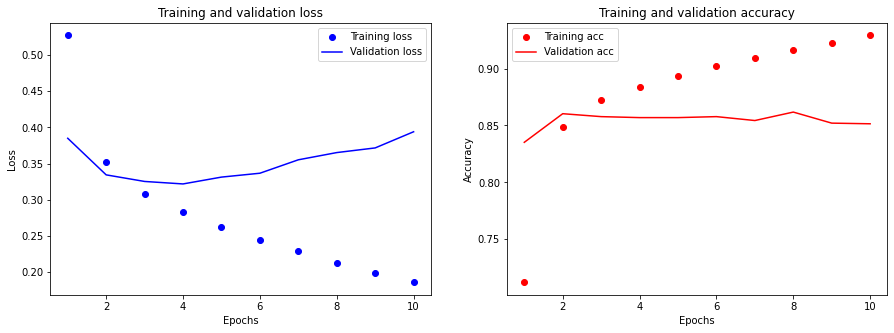

In [80]:
acc8 = history8_dict['accuracy']
val_acc8 = history8_dict['val_accuracy']
loss8 = history8_dict['loss']
val_loss8 = history8_dict['val_loss']

epochs = range(1, len(acc8) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(epochs, loss8, 'bo', label='Training loss')
plt.plot(epochs, val_loss8, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc8, 'ro', label='Training acc')
plt.plot(epochs, val_acc8, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- LSTM에 Adam을 적용한 모델의 Training & Validation 결과를 보자.
- 먼저 loss 값을 보면 training loss는 점차적으로 줄어가지만, validation은 하강하는 양상을 보이다가 다시 증가하는 것을 볼 수 있다. 
- accuracy 를 보면 training acc는 점차적으로 상향하는 형태를 보이지만, validation은 큰 변동이 없는 것으로 보인다.

In [54]:
# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size,
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 40, 200)           2000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 8)                 6688      
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [55]:
model.compile(optimizer='RMSprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history9 = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
1115/1115 [==============================] - 17s 13ms/step - loss: 0.6172 - accuracy: 0.6168 - val_loss: 0.3700 - val_accuracy: 0.8351
Epoch 2/10
1115/1115 [==============================] - 15s 14ms/step - loss: 0.3651 - accuracy: 0.8389 - val_loss: 0.3341 - val_accuracy: 0.8549
Epoch 3/10
1115/1115 [==============================] - 15s 14ms/step - loss: 0.3308 - accuracy: 0.8589 - val_loss: 0.3202 - val_accuracy: 0.8666
Epoch 4/10
1115/1115 [==============================] - 15s 14ms/step - loss: 0.3101 - accuracy: 0.8687 - val_loss: 0.3206 - val_accuracy: 0.8657
Epoch 5/10
1115/1115 [==============================] - 15s 14ms/step - loss: 0.3010 - accuracy: 0.8727 - val_loss: 0.3103 - val_accuracy: 0.8686
Epoch 6/10
1115/1115 [==============================] - 15s 14ms/step - loss: 0.2896 - accuracy: 0.8783 - val_loss: 0.3149 - val_accuracy: 0.8726
Epoch 7/10
1115/1115 [==============================] - 15s 14ms/step - loss: 0.2786 - accuracy: 0.8832 - val_loss: 0.3089 -

In [56]:
results9 = model.evaluate(X_test,  y_test, verbose=2)

print(results9)

1537/1537 - 5s - loss: 0.3268 - accuracy: 0.8586
[0.3267643451690674, 0.858555257320404]


In [57]:
history9_dict = history9.history

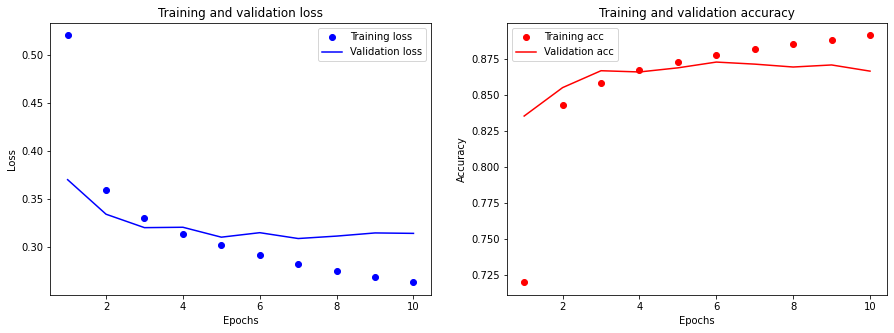

In [81]:
acc9 = history9_dict['accuracy']
val_acc9 = history9_dict['val_accuracy']
loss9 = history9_dict['loss']
val_loss9 = history9_dict['val_loss']

epochs = range(1, len(acc9) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(epochs, loss9, 'bo', label='Training loss')
plt.plot(epochs, val_loss9, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc9, 'ro', label='Training acc')
plt.plot(epochs, val_acc9, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- LSTM에 RMSprop을 적용한 모델의 training & validation 결과를 확인해보자.
- training loss는 하향하는 모습, 그리고 validation loss는 하향하다가 일정 수준을 유지하는 모습을 보인다.
- training acc는 상향하는 모습, validation acc는 역시 상향하다가 일정한 값을 유지하는 것을 볼 수 있다.

<Figure size 432x288 with 0 Axes>

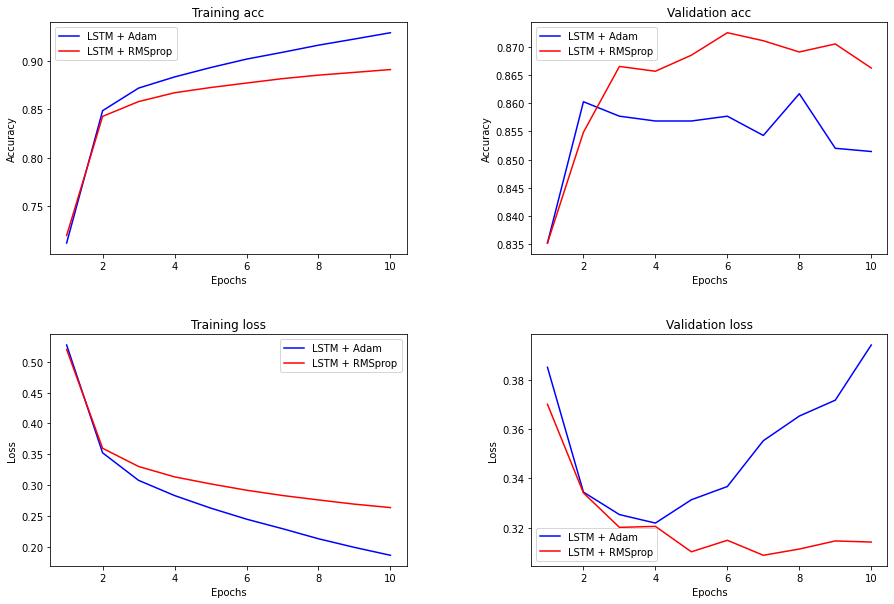

In [59]:
epochs = range(1, len(acc9) + 1)

plt.clf() 

plt.figure(figsize=(15, 10))
plt.subplots_adjust(wspace=0.35, hspace=0.35)

plt.subplot(221)
plt.plot(epochs, acc8, 'b', label='LSTM + Adam')
plt.plot(epochs, acc9, 'r', label='LSTM + RMSprop')
plt.title('Training acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(222)
plt.plot(epochs, val_acc8, 'b', label='LSTM + Adam')
plt.plot(epochs, val_acc9, 'r', label='LSTM + RMSprop')
plt.title('Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(223)
plt.plot(epochs, loss8, 'b', label='LSTM + Adam')
plt.plot(epochs, loss9, 'r', label='LSTM + RMSprop')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(224)
plt.plot(epochs, val_loss8, 'b', label='LSTM + Adam')
plt.plot(epochs, val_loss9, 'r', label='LSTM + RMSprop')
plt.title('Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

- 두 모델의 training & validation 결과를 함께 보자.
- 이번에도 역시 Training 결과에서는 Adam을 적용한 모델이 우세하지만, validation에서는 RMSprop을 적용한 모델이 더 우세한 것을 볼 수 있다.
- 아무래도 LSTM 모델에는 RMSprop을 사용하는 것이 효과가 좋은 것 같다.

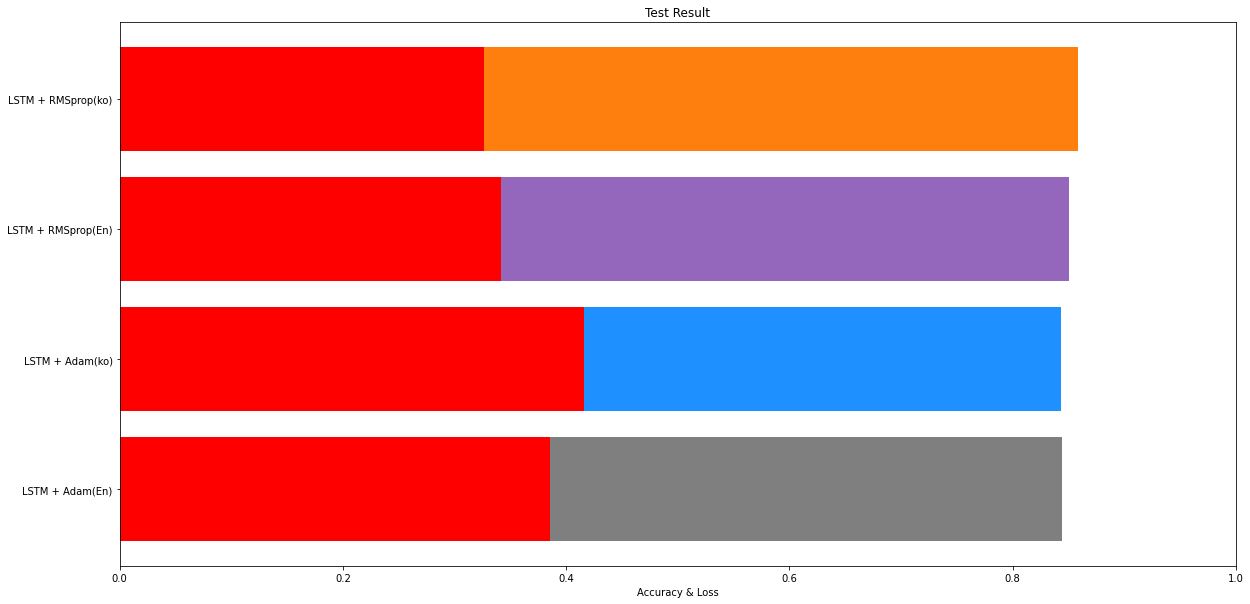

In [74]:
m1_tacc = results1[1]
m1_tloss = results1[0]

m5_tacc = results5[1]
m5_tloss = results5[0]

tloss8=results8[0]
tloss9=results9[0]
tacc8=results8[1]
tacc9=results9[1]

k = np.arange(4)
label3 = ['LSTM + Adam(En)', 'LSTM + Adam(ko)', 'LSTM + RMSprop(En)', 'LSTM + RMSprop(ko)']
test_accs4 = [m1_tacc, tacc8, m5_tacc, tacc9]
test_loss4 = [m1_tloss, tloss8, m5_tloss, tloss9]
colors = ['C7', 'dodgerblue', 'C4', 'C1']

plt.figure(figsize=(20,10))

plt.subplot(111)
plt.barh(k, test_accs4, color=colors)
plt.barh(k, test_loss4, color='r')
plt.yticks(k, label3)
plt.xlim([0,1])
plt.title('Test Result')
plt.xlabel('Accuracy & Loss')

plt.show()

In [77]:
for i in range(4):
    print("{} -  test acc:{}, test loss: {}".format(label3[i], test_accs4[i], test_loss4[i])) 

LSTM + Adam(En) -  test acc:0.8440710306167603, test loss: 0.3856655955314636
LSTM + Adam(ko) -  test acc:0.8431352376937866, test loss: 0.416003555059433
LSTM + RMSprop(En) -  test acc:0.8506011366844177, test loss: 0.34131869673728943
LSTM + RMSprop(ko) -  test acc:0.858555257320404, test loss: 0.3267643451690674


-  위 그래프와 수치를 통해 한국어 Word2Vec을 활용한 효과를 확인해보자.
- 위 결과들은 각 모델들의 test acc와 test loss 를 나타낸 것이다.
- LSTM+Adam 모델들에서는 미세하지만 결과가 더 안좋게 나왔다.
- LSTM+RMSprop 모델들에서는 미세하지만 ko 모델의 acc는 상승하였고, loss도 줄어들은 것을 볼 수 있다.

---
## 9. 평가





|  **No.**  |  **구분** | <center> **내용** </center> |
|:----:|:----:|:----|
| **01** | **평가 문항** | 1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다. |
| **02** | **상세 기준** | 3가지 이상의 모델이 성공적으로 시도됨 |
| **03** | <center>**나의 평가**</center> | 'LSTM Adam', '1-D CNN', 'GlobalMaxPooling1D', 'LSTM-SGD','LSTM-RMSprop', 'LSTM-Adagrad', 'LSTM-Adamax'로 총 7개의 모델을 사용하여 테스트 해보았음 |


|  **No.**  | **구분** | <center>**내용**</center> |
|:----:|:----:|:----|
| **01** | **평가 문항** | 2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다. |
| **02** | **상세 기준** | gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함 |
| **03** | **나의 평가** | gensim을 이용하여 유사 단어를 확인해보았으나, 제시한 단어와 크게 관련되지 않은 단어들이 높은 유사도를 가진 것으로 결과가 나왔다. 이는 영어 Word2Vec를 활용해서 인것으로 생각되어 한국어 Word2Vec을 사용하였다. 결과적으로 제시된 단어와 유사한 단어들이 출력된 것을 확인할 수 있었다.|



|  **No.** | **구분** | <center>**내용** </center> |
|:----:|:----:|:----|
| **01** | **평가 문항** | 3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다. |
| **02** | **상세 기준** | 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함 |
| **03** | **나의 평가** | 한국어 Word2Vec을 활용하여 LSTM+RMSprop의 accracy를 높이고 loss 값을 낮췄다. 괄목할만한 결과는 아니었지만 성능 향상이 보였던 부분이 있었다. 하지만 LSTM+Adam 모델에서는 오히려 결과값이 안좋게 나왔다. 이 부분은 조금 더 공부해서 확인해봐야할 것 같다. 결과적으로는  LSTM+RMSprop 모델을 통해 정확도 85% 이상의 결과를 달성하였다.|
    


--- 

## 10. 회고



- 이번 프로젝트를 진행하면서 이전에 배운 내용들을 많이 찾아봤다. 그 만큼 학습해온 내용을 복합적으로 많이 사용했던 것 같고, 몰랐던 부분들을 알게 된 것 같아서 좋았던 것 같다.
- 특히 프로젝트를 진행하면서 에러가 정말 많이 났다. 에러를 해결하기 위해 서치를 많이 해봤지만 모든 오류를 해결하기엔 어려움이 있었다. 
- '그럼 어떻게 해결했는가?' 라고 묻는다면 ... 작성한 코드를 정말 오래보니 답이 나왔다. 이 부분에서 정말 크게 배웠다.
- 코드를 작성할 때 무지성으로 작성하지않고 내 코드에 대해서 정확한 이해를 해야하고, 맞는 흐름으로 작성하고 있는지도 체크해가야 한다는 생각이 들었다.
- 이번 프로젝트를 한 모든 순간이 그 동안 배운 것을 정리하고, 새로운 함수나 모듈을 알게 되고, 내 코드 리뷰도 매우 중요하다는 사실 등을 배운 귀하고 의미있었던 시간이었던 것 같다.

---
## 참고자료

[Pandas-DataFrame에서 행 삭제 및 추가](https://blog.naver.com/PostView.nhn?blogId=rising_n_falling&logNo=221629326893)